# Обучение ранжированию | Learning to Rank

Раньше перед нами стояла задача, что у нас есть какой-то $X$ и нам нужно найти такую функцию $a(x)$, которая будет предсказывать $y$, причём этот $y$ может быть числом, либо конечным множеством ответов.

Теперь:

Пользователь приносит какой-то запрос $q$, и в ответ на этот запрос поиск должен выдавать ответ: отсортированный по определённому порядку набор документов, ссылок и тд из интернета.

Что такое правильный порядок: вверху этой выдачи должны стоять самые релевантные документы.

**Постановка задачи:**
(будем всё сводить на примере поискового ранжирования)
$q_1, q_2, ... , q_n$ - запросы
$d_1, d_2, ... , d_n$ - документы

1.   $X = (q_i, π_i(d_1, ..., d_n))_{i=1}^l$

     $a = X → S(d1, ..., d_n)$

     => listwise approach

     Проблемы: высокая сложность из-за перестановок, пространство ответов очень большое, возможность получения одинаковых перестановок
2.   $X = (q_i, d_i^1, d_i^2)_{i=1}^l$

     $a(q, d) → $ оценка релевантности

     $a(q_i, d_i^1) < a(q_i, d_i^2)$

     то есть $d_i^2$ больше подходит к $q_i$, чем $d_i^1$

     => pairwise approach

3.   $X = (q_i, d_i, y_i)_{i=1}^l$

     $y_i$ - релевантность $d_i$ для $q_i$

     $y_i ∈ {0, 1}$

     $y_i ∈ {1, ..., n}$

     $y_i ∈ ℜ$  

     => pointwise approach




## Метрики (зависят от постановки задачи)

1.   Поточечная:

$X = (q_i, d_i, y_i)_{i=1}^l$

$a(q, d) = y$ - модель регрессии\классификации, поэтому берём метрики из этого блока задач (ROC-AUC неплох)

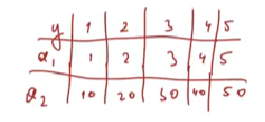

Обе модели идеальные, но вторая по MSE ужасная

2.   Попарные

доля дефектных пар:

$X = (q_i, d_i^1, d_i^2)_{i=1}^l$

$a(q_i, d_i^1) < a(q_i, d_i^2)$

$Σ[a(q_i, d_i^1) >= a(q_i, d_i^2)] → min$

- связано с ROC-AUC

- доля объектов, на котрых модель не справилась с тем, чтобы эти пары упорядочить

3.   Списочные:

$X = (q_i, π_i(d_1, ..., d_n))_{i=1}^l$

$a = X → S(d1, ..., d_n)$

Самые "тупые" (бинарная релевантность):

документы либо подходят под запрос, либо не подходят (да/нет)

$precision@K = \frac{1}{K} Σ_{i=1}^K [y_{(i)} = 1]$

$y_{(i)}$ - документ, который модель поставит на i-ю позицию

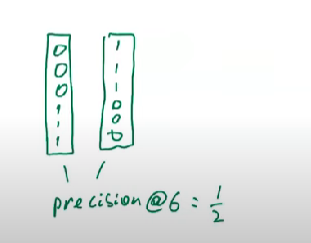

Проблему выше решает average precision:

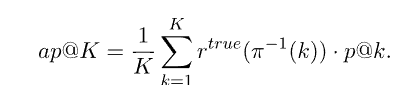

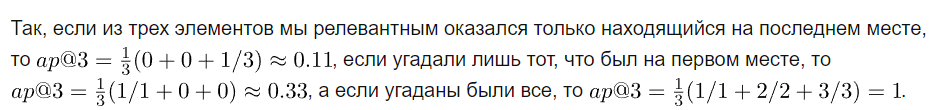

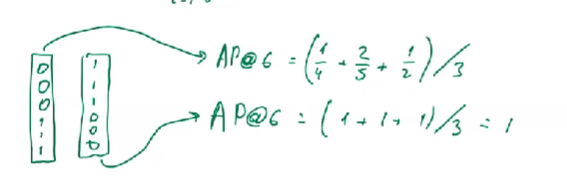

AP - то же самое, что и площадь под Precision-Recall кривой

$MAP@K = \frac{1}{|Q|}Σ_{q=Q} AP@K(q)$ - mean average precision

 Суть AP - в том, что мы хотим, чтобы выше релевантного документа стояли только релевантные (минимизировать случаи попадания выше нерелевантных)

**Менее "тупые" метрики (шкала релевантности):**

$y \in {1, ..., K}$

$y \in ℜ$

Источники данных:

*   клики пользователей (проблема - в начале поискового запроса могут быть кликбейтные ссылки, либо пользователи не совсем понимают, норм сайт или нет)

*   асессоры (отмечают данные от 1 до 5 по специальной инструкции, много критериев)


(Discounted cumulative gain at K) $DCG@K (q) = Σ_{i=1}^K g(y_{(i)}) d(i)$, где g - функция, которая "поощряет" за то, что мы поставили релевантные документы, а d - функция, которая штрафует за эту позицию, иными словами веса для позиций

$g(y) = 2^y$

$d(i) = \frac{1}{log(1+i)}$

=> $Σ\frac{2^y_{(i)}}{log(1+i)}$ - хорошо, что мы нашли какой-то релеватный документ, но плохо, что мы поставили его в конец поисковой выдачи

Normalized DCG = $nDCG@K(q) = \frac{DCG@K(q)}{\underset{a}{max}DCG@K(q)} \in [0,1]$, когда отсортировали первые q документов по y




**Умные метрики (каскадные):**

Например, есть две поисковые выдачи, мы спрашиваем у пользователя какая из них ему нравится больше:

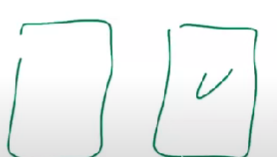

Мы собираем много таких попарных сравнений поисковых выдачей и хотим чтобы наша метрика коррелировала с мнениями пользователей.

Есть две похожие PFound и ERR

**PFound**

$y_i \in [0, 1]$ - вероятность найти ответ в документе

$p_i$ - вероятность дойти до i-й позиции в выдаче

$p_1 = 1$

$p_{i+1} = p_i * (1-y_{(i)}) * (1-p_{out})$, первое - не нашел ответ в i-м, второе - вероятность что не устанет

$PFound@K(q) = Σ_{i=1}^K p_i * y_{(i)}$

У PFound бдует экспоненциальное затухание, что логично, поскольку пользователи редко доходят до условно 20-го документа

## Признаки в ранжировании

1.   Запросные:
    - язык
    - тип (навигационный, товарный)
    - эмбеддинг запроса
    - регион
    - частотность

2.   Статические:
    - тема
    - свойства url
    - эмбеддинг документа

3.   Динамические ($<w_q, w_d>$):
    - расстояние между эмбеддингами
    - модель


Примеры исторические:

BM25(давно, вероятностная модель поведения пользователя)

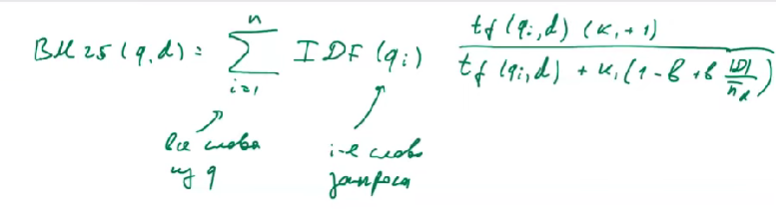

Page Rank (уже не используется, легко можно заабузить)

Если на d эксклюзивно ссылается много другмх документов, то это хорошо (например, какие-то статьи в интернете ссылаются на один и тот же материал теории и тд)

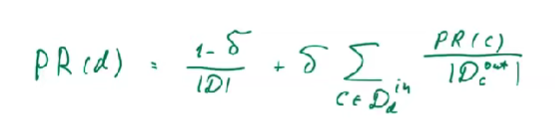



## Методы ранжирования

**Pointwise**

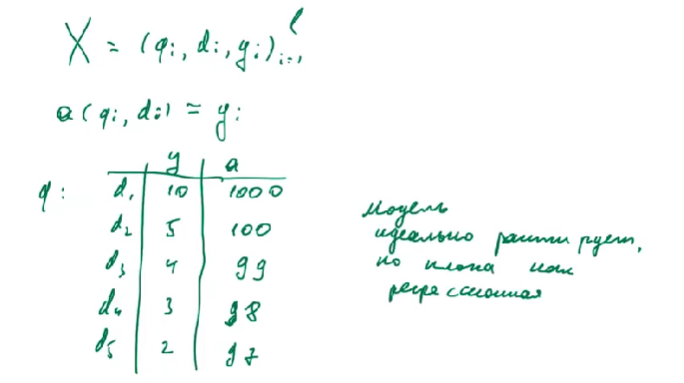

**Pairwise**

$R = (i_k, j_k)_{u=1}^l$

$(q_{i_k}, d_{i_k}), (q_{j_k}, d_{j_k})$

$q_{i_u} = q_{j_u}$ - для одного запроса

$(i, j) \in R => a(q_i, d_i) < a(q_j, d_j) \space aka a(x_i) < a(x_j)$

$Σ_{(i, j) \in R} \space [a(x_j) - a(x_i) < 0] <= Σ_{(i, j) \in R} \space L(a(x_j) - a(x_i)) → min$

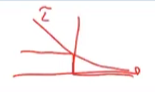

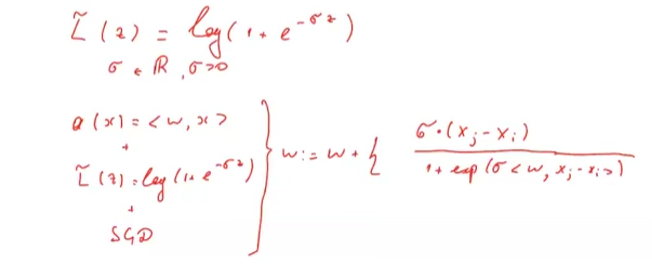

Название метода: **RankNet**

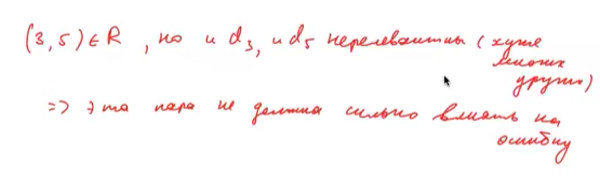

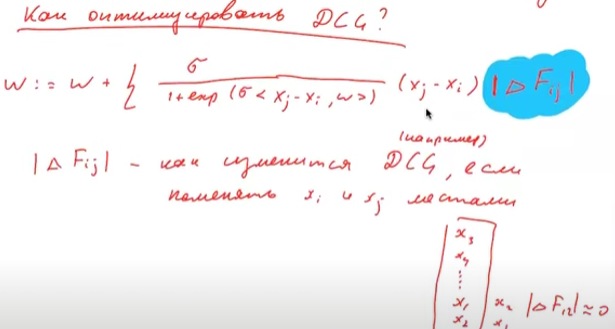

Нзвание метода: **LambdaRank**

**DSSM (deep structured semantic model) / (сиамская сеть)**

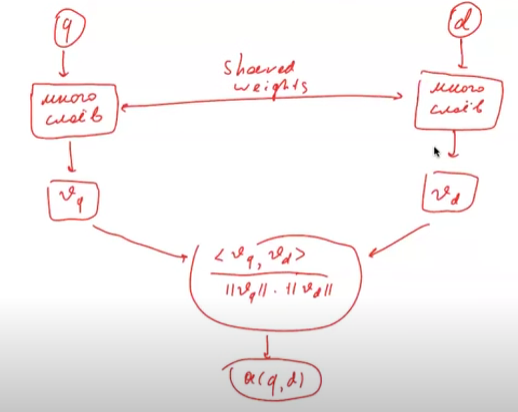

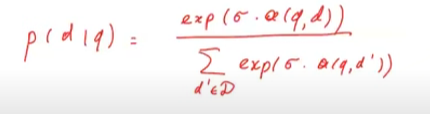

Проблема: слишком много слагаемых в знаменателе

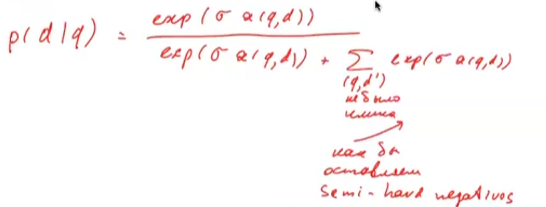

**Listwise**

Listnet:

$q → d_1, ... , d_{n_q}$

$\space \space \space \space \space \space \space \space  y_1, ... , y_{n_q}$ - истинная релевантность

$\space \space \space \space \space \space \space \space  z_1, ... , z_{n_q}$ - из модели $(z_i = a(q, d_i))$

Цель: максимизировать DCG (или другую метрику) для ранжирования, задаваемого моделью

Пусть модель выдает вероятностное распределение на всех перестановках (есть 10 документов, 10! перестановок, для каждой будет предсказываться ее вероятность)

Plackett-Luce Distribution

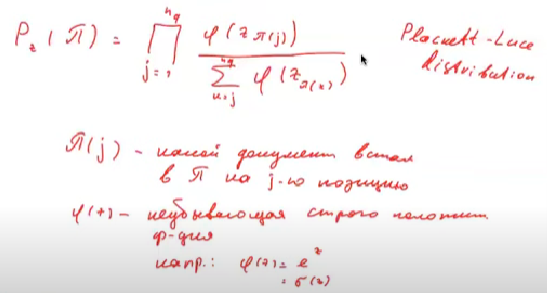

Свойства:

- это распределение

- если делается перестановка, менее согласованная с моделью, то вероятность такой перестановки понижается

- максимальная вероятность у перестановки, которая сортирует по убыванию z


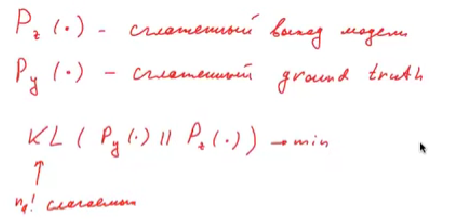

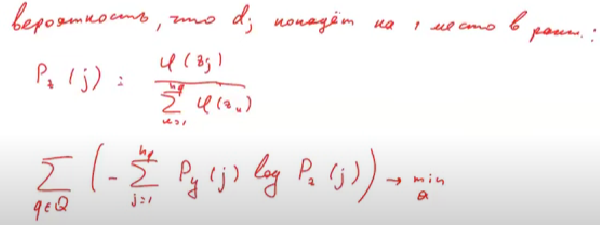

SoftRank:

модель $a(q, d_j)$ выдает скор $S_j$

$p(S_j) = 𝒩(a(q, d_j), σ_s^2)$ - релевантность распределена нормально с центром в a и с некоторой дисперсией (некоторое распредление)

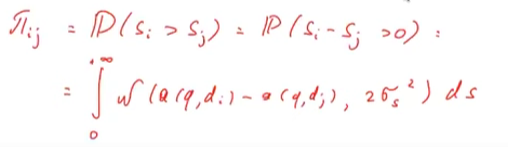

-вероятность, что $d_i$ окажется выше $d_j$

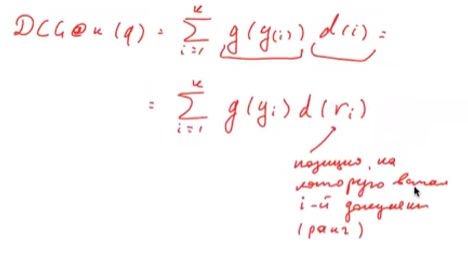

Хотим найти распределение $r_j$ - позиций, куда модель поставит j-й документ

Rank-Binomial distribution - распределение кол-ва успехов в N-1 соревнований, у каждого из которых своя вероятность победы (вероятности независимые и считаются итерационно)

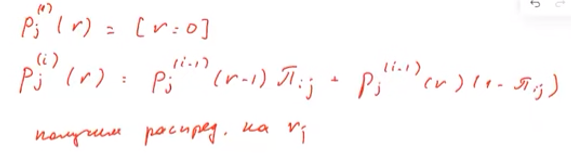

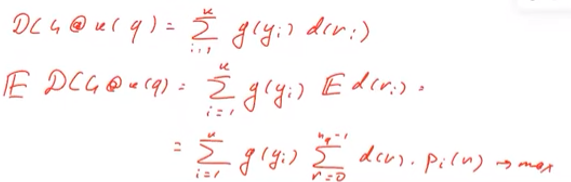


